<a target="_blank" href="https://colab.research.google.com/github/SLCFLAB/Fintech2025-2/blob/main/ML_day2/2_1_Regression_Penalty.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# ML_Day2_1

ref: https://github.com/codingalzi/handson-ml2/blob/master/notebooks/handson-ml2-04.ipynb

## 주요 내용

- Shirinkage Method, Model Legularization

__참고:__ 
핵심 설명과 코드는 &#x1f511;로 표시되었으며 굳이 알아둘 필요가 없는 코드는 &#x270b;로 표시되었다.

## 기본 설정

- 필수 모듈 불러오기
- 그래프 출력 관련 기본 설정 지정

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# 어레이 데이터를 csv 파일로 저장하기
def save_data(fileName, arrayName, header=''):
    np.savetxt(fileName, arrayName, delimiter=',', header=header, comments='')

## 규제를 사용하는 선형 모델

모델의 학습 과정에 규제를 가하는 방식으로 과대 적합을 감소시킬 수 있다.
다항 회귀 모델의 경우 다항식의 차수를 감소시키는 방식으로 규제할 수 있다.

선형 회귀 모델의 규제는 학습되는 일반적으로 파라미터에 제한을 두는 방식으로 이루어지며,
여기서는 다른 규제 방식이 적용된 세 모델을 소개한다.

* 릿지 회귀 (L2)
* 라쏘 회귀 (L1)
* 엘라스틱넷

또한 경사하강법과 같은 반복적인 학습 알고리즘의 검증 오류가 최솟값에 도달한 지점에 훈련을 중지시키는 
__조기 종료__ 기법도 소개한다.

### 릿지 회귀

아래 코드는 연습을 위해 1차 함수를 이용하여 20개의 훈련 데이터를 생성한다.

* `X`: 훈련 세트, 크기는 20.
* `X_new`: 100개의 검증용 데이터.

In [2]:
np.random.seed(42)

m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5     # 1차 선형회귀 모델을 따로도록 함. 단, 잡음 추가됨.
X_new = np.linspace(0, 3, 100).reshape(100, 1)    # 0~3 구간에서 균등하게 100개의 검증 데이터 선택

#### 릿지 회귀의 비용 함수

$$
\begin{align*}
J(\boldsymbol{\theta}) & = \text{MSE}(\boldsymbol{\theta}) + \dfrac{\alpha}{2}\sum\limits_{i=1}^{n}{\theta_i}^2 \\
& = \text{MSE}(\boldsymbol{\theta}) + \dfrac{\alpha}{2}\left (\theta_1^2 + \cdots + \theta_n^2 \right )
\end{align*}
$$

#### `Ridge` 모델

릿지 규제를 지원한다.

* `solver=cholesky`: 원래는 경사하강법을 계산하는 옵티마이저 지정. 
    하지만 `cholesky`를 지정하면 정규방정식을 이용하여 최적의 파라미터를 계산함.
* `alpha=1`: 규제 강도를 나타냄. 값이 클 수록 규제가 세짐. 이유는 비용 함숫값을 줄이기 위해
    $\theta_i$ 값들이 작아지도록 강요되기 때문임.

In [3]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([1.55071465])

* `solver=sag`: 경사하강법을 지원하는 다양한 옵티마이저 중에 하나임. 계속해서 보다 개선된 옵티마이저가 개발됨.

In [4]:
ridge_reg = Ridge(alpha=1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([1.55072189])

아래 코드는 다양한 `alpha` 값의 영향력를 그래프로 보여준다.
오른편 그래프는 10차 다항 회귀가 적용된 경우 3 개를 보여준다. 
`alpha`를 크게 할 수록 예측값의 그래프가 직선에 가까워짐을 볼 수 있다.

그림 저장: ridge_regression_plot


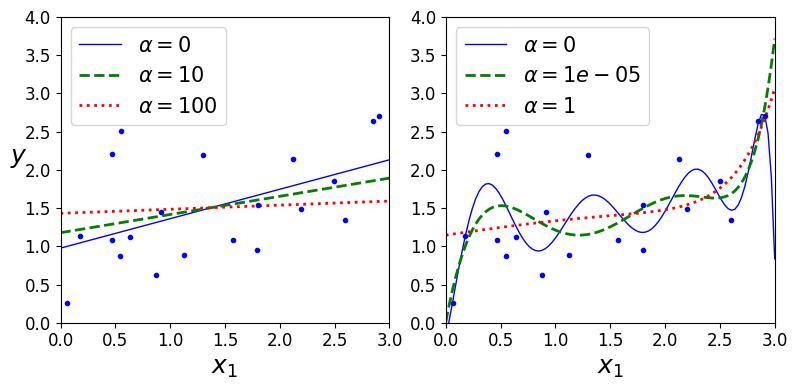

In [5]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),           # 표준화 축척 조정
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

save_fig("ridge_regression_plot")
plt.show()

### 라쏘 회귀

#### 라쏘 회귀의 비용 함수

$$
\begin{align*}
J(\boldsymbol{\theta}) & = \text{MSE}(\boldsymbol{\theta}) + \alpha \sum\limits_{i=1}^{n}\left| \theta_i \right| \\
& = \text{MSE}(\boldsymbol{\theta}) + \alpha \left (\, \left| \theta_1 \right| + \cdots + \left| \theta_n \right|\, \right )
\end{align*}
$$

#### `Lasso` 모델

라쏘 규제를 지원한다.

* `alpha=0.1`

__참고:__ 릿지 회귀에 사용된 `alpha` 값보다 작은 값을 사용하였다. 
이유는 릿지 회귀는 파라미터를 제곱해서 사용하는 반면에 라쏘 회귀에서는 파라미터의 절댓값을 사용하기 때문에
`alpha`가 작더라도 규제에 큰 영향을 주기 때문이다.

In [6]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

아래 코드는 라쏘 규제에 사용되는 다양한 `alpha` 값의 영향을 비교해준다.
오른편 그래프는 10차 다항회귀에 적용된 라쏘 회귀 모델의 예측값을 보여준다.
10차 다항 회귀라 하더라도 규제를 세개 주면 마치 3차 다항회귀를 준 것처럼 작동하게 함을 잘 보여준다.

c:\Users\shin0\anaconda3\envs\vqvae\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.803e+00, tolerance: 9.295e-04
  model = cd_fast.enet_coordinate_descent(


그림 저장: lasso_regression_plot


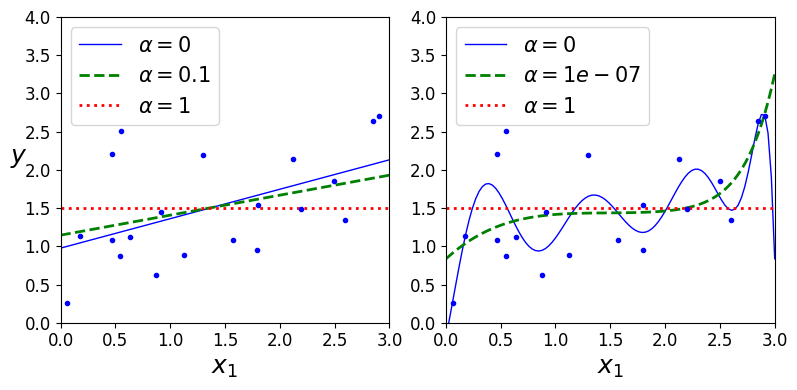

In [7]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), random_state=42)

save_fig("lasso_regression_plot")
plt.show()

아래 코드는 라쏘 회귀와 릿지 회귀 모델 학습 과정 동안 경사 하강법이 적용될 때
파라미터가 움직이는 특성을 비교해서 보여주기 위한 코드이다.

핵심은 다음과 같다.

- 상단 왼편: $\ell_1$ 노름의 그레이디언트 벡터의 움직임. 
    $\theta_2$처럼 파라미터 값이 작을 수록 먼저 0에 수렴하는 것이 보여짐.
    훈련 과정에서는 별로 중요하지 않은 속성을 빠르게 무시하는 효과를 보여줌.
- 상단 오른편: $\ell_1$ 노름이 추가된 평균 제곱 오차(MSE) 함수의 그레이디언트 벡터의 움직임.
    $\theta_2$가 먼저 줄어드는 것을 잘 보여줌.
    전역 최저점에 근처에서 진동함. 이유는 절댓값의 미분이 0에서 정의되어 있지 않기 때문임.
- 하단 왼편: $\ell_2$ 노름의 그레이디언트 벡터의 움직임. 
    모든 파라미터가 원점에 직선으로 달려가는 형태로 줄어듬.
- 하단 오른편: $\ell_2$ 노름이 추가된 평균 제곱 오차(MSE) 함수의 그레이디언트 벡터의 움직임.
    파라미터가 전역 최저점 근처에서 느려짐. 이유는 그레이디언트가 작아지기 때문임.

In [8]:
# 도표에 사용되는 좌표값 모음
t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[1, 1], [1, -1], [1, 0.5]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1/len(Xr) * np.sum((T.dot(Xr.T) - yr.T)**2, axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(np.argmin(J), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

그림 저장: lasso_vs_ridge_plot


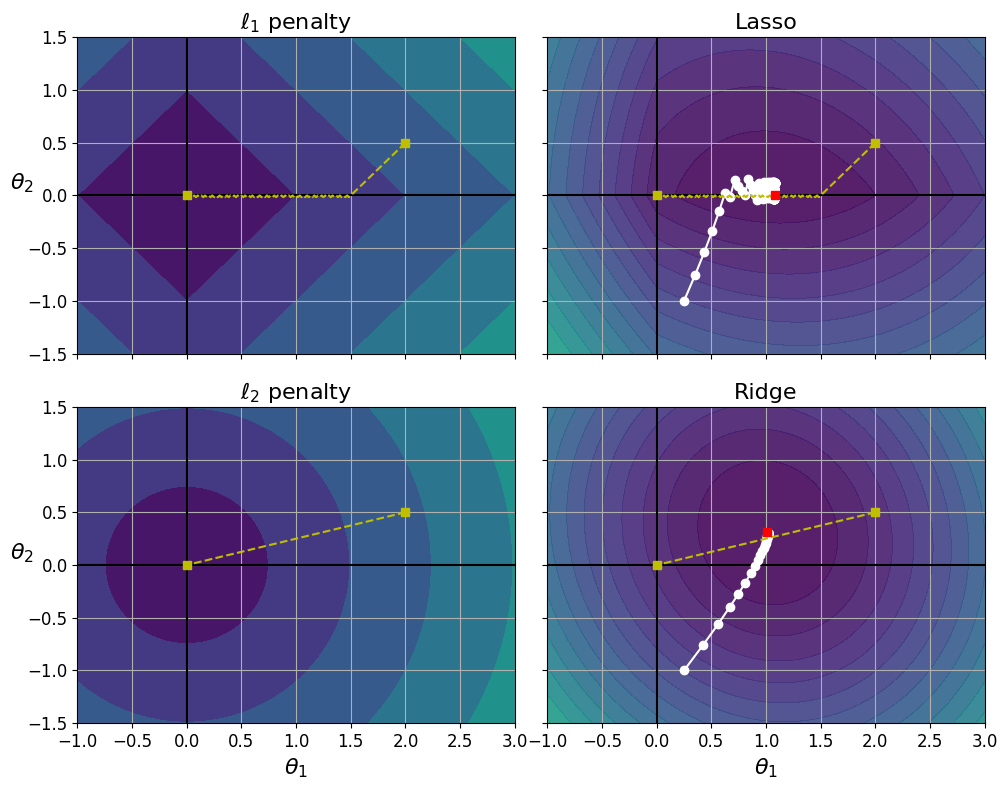

In [9]:
# 파라미터(theta) 경로 기억 어레이 생성 함수
def bgd_path(theta, X, y, l1, l2, core = 1, eta = 0.05, n_iterations = 200):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = core * 2/len(X) * X.T.dot(X.dot(theta) - y) + l1 * np.sign(theta) + l2 * theta
        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10.1, 8))
for i, N, l1, l2, title in ((0, N1, 2., 0, "Lasso"), (1, N2, 0,  2., "Ridge")):
    JR = J + l1 * N1 + l2 * 0.5 * N2**2
    
    tr_min_idx = np.unravel_index(np.argmin(JR), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]
    
    # 좌측 도표 등고선 용도
    levelsN=np.linspace(0, np.max(N), 10)
    levelsJR=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(JR) - np.min(JR)) + np.min(JR)
    
    # 라쏘 또는 릿지 회귀 경사하강법 파라미터 경로
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    
    # l1 노름 또는 l2 노름 경사하강법 경로
    path_N = bgd_path(np.array([[2.0], [0.5]]), Xr, yr, np.sign(l1)/3, np.sign(l2), core=0)
    
    # 좌측 도표(상단: 라쏘, 하단: 릿지)
    ax = axes[i, 0] 
    ax.grid(True)
    ax.axhline(y=0, color='k')                                     # x 축
    ax.axvline(x=0, color='k')                                     # y 축
    ax.contourf(t1, t2, N / 2., levels=levelsN)                    # 등고선
    
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")                     # 노랑 점선
    ax.plot(0, 0, "ys")                                            # 원점
    ax.plot(t1_min, t2_min, "ys")                                  # 좌표 (2, 1)
    ax.set_title(r"$\ell_{}$ penalty".format(i + 1), fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)
    ax.set_ylabel(r"$\theta_2$", fontsize=16, rotation=0)

    # 우측 도표(상단: 라쏘, 하단: 릿지)
    ax = axes[i, 1]   
    ax.grid(True)
    ax.axhline(y=0, color='k')                                      # x 축
    ax.axvline(x=0, color='k')                                      # y 축
    ax.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)             # 등고선
    
    ax.plot(path_JR[:, 0], path_JR[:, 1], "w-o")                    # 흰색 점실선
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")                      # 노랑 점선
    ax.plot(0, 0, "ys")                                             # 원점
    ax.plot(t1_min, t2_min, "ys")                                   # 좌표 (2, 1)
    ax.plot(t1r_min, t2r_min, "rs")                                 # 빨강 점
    ax.set_title(title, fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)

save_fig("lasso_vs_ridge_plot")
plt.show()